In [43]:
import pandas as pd
from citipy import citipy
import numpy as np
import csv
from datetime import datetime as dt, timedelta
import json
from pandas.io.json import json_normalize

#import data
weather = pd.read_json("ow.json") #1/1/2013-1/1/2020 hourly weather data
crime = pd.read_csv("crime.csv")

In [2]:
drop_list = ['GEO_X', 'GEO_Y', 'DISTRICT_ID', 
             'REPORTED_DATE', 'LAST_OCCURRENCE_DATE',
            'INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE_EXTENSION']
crime.drop(columns=drop_list, inplace=True)



In [3]:
crime = crime.rename(columns = {'OFFENSE_CODE':'Code', 
                               'OFFENSE_TYPE_ID':'Offense_Type', 
                               'INCIDENT_ADDRESS':'Address', 
                               'GEO_LON':'Lon',
                               'GEO_LAT':'Lat', 
                               'PRECINCT_ID':'Precint', 
                               'NEIGHBORHOOD_ID':'Neighborhood'})

In [4]:
#expand list from columns into new databases
weather_temp = (json_normalize(weather['main']))
weather_wind = json_normalize(weather['wind'])
weather_clouds = json_normalize(weather['clouds'])


In [5]:
#create new columns for desired fields from expanded list
weather_temp.head()
weather['Temp'] = weather_temp['temp']
weather['Temp Max'] = weather_temp['temp_max']
weather['Wind'] = weather_wind.speed
weather['Clouds'] = weather_clouds
#split date iso into columns, then delete unwanted columns 
weather[['Date','Hour', 'Trash', 'Trash2']] = weather.dt_iso.str.split(expand=True)
columns = ['wind', 'clouds', 'weather','main', 'timezone', 'snow', 'rain', 'dt', 'Trash', 'Trash2', 'dt_iso', 'lat', 'lon']
weather.drop(columns=columns, inplace=True)


In [6]:
#create dataframe for speends over 40mph 
wind_df = weather.loc[weather.Wind > 40]
wind_df
weather['Date & Time'] = weather['Date'] + ' ' + weather['Hour']
weather['Date & Time'] = weather['Date & Time'].astype('datetime64[ns]')
weather = weather.drop(columns =['Date', 'Hour'])


In [7]:
#create dataframe for temps under 10f 
cold_df = weather.loc[weather['Temp Max'] < 10]


In [8]:
crime['Date'] = pd.to_datetime(crime['FIRST_OCCURRENCE_DATE'])


In [9]:
crime.head()
crime.drop(columns=['FIRST_OCCURRENCE_DATE'], inplace=True)

In [23]:
# df = pd.DataFrame([{'old_column':pd.Timestamp('2015-07-18 13:53:33.280')}])
crime['Date'] = crime['Date'].dt.round('60min')

In [24]:
weather.head()
weather = weather.rename(columns = {'Date & Time':'Date'})

In [12]:
# remove incorrect lat longs skewing data
crime = crime[crime["Lon"] <= -104.2]
crime = crime[crime["Lon"] >= -105.5]
crime = crime[crime["Lat"] >= 39.5]
crime = crime[crime["Lat"] <= 40.0]

crime_weather = pd.merge(crime, weather, on='Date', how='left')


In [13]:
crime_weather.to_csv('crime_weather.csv')

# What CRIME occurs the most in cold, warm, and hot temperatures?

In [33]:
cw_path = pd.read_csv('crime_weather.csv')
cw_orig = pd.DataFrame(cw_path)

In [34]:
# bin by temperature ranges
bins = [-50, 10, 40, 70, 100, 150]
temp_names = ["Really Cold","Cold","Warm","Hot","Really Hot"]
cw_orig["Temp Range"] = pd.cut(cw_orig['Temp'], bins, labels=temp_names)
cw_orig.head()

,Unnamed: 0,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date,city_name,Temp,Temp Max,Wind,Clouds,Temp Range
0,0,5213,weapon-unlawful-discharge-of,all-other-crimes,NaN,-104.809881,39.773188,521,montbello,1,0,2016-06-16 00:00:00,Denver,89.69,93.99,18.34,20.0,Hot
1,1,2399,theft-other,larceny,NaN,-104.781434,39.785649,522,gateway-green-valley-ranch,1,0,2017-10-11 12:00:00,Denver,40.77,41.00,4.70,1.0,Warm
2,2,2305,theft-items-from-vehicle,theft-from-motor-vehicle,2932 S JOSEPHINE ST,-104.957381,39.663490,314,wellshire,1,0,2016-03-04 20:00:00,Denver,55.90,57.20,11.41,75.0,Warm
3,3,2399,theft-other,larceny,705 S COLORADO BLVD,-104.941440,39.702698,312,belcaro,1,0,2018-01-30 19:00:00,Denver,57.88,62.60,19.69,75.0,Warm
4,4,2303,theft-shoplift,larceny,2810 E 1ST AVE,-104.955370,39.717107,311,cherry-creek,1,0,2017-06-22 21:00:00,Denver,79.86,84.38,19.69,75.0,Hot


In [62]:
# filter out traffic violations
iscrime_df = cw_orig[cw_orig['IS_CRIME']==1]
iscrime_df.head()

,Unnamed: 0,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date,city_name,Temp,Temp Max,Wind,Clouds,Temp Range
0,0,5213,weapon-unlawful-discharge-of,all-other-crimes,NaN,-104.809881,39.773188,521,montbello,1,0,2016-06-16 00:00:00,Denver,89.69,93.99,18.34,20.0,Hot
1,1,2399,theft-other,larceny,NaN,-104.781434,39.785649,522,gateway-green-valley-ranch,1,0,2017-10-11 12:00:00,Denver,40.77,41.00,4.70,1.0,Warm
2,2,2305,theft-items-from-vehicle,theft-from-motor-vehicle,2932 S JOSEPHINE ST,-104.957381,39.663490,314,wellshire,1,0,2016-03-04 20:00:00,Denver,55.90,57.20,11.41,75.0,Warm
3,3,2399,theft-other,larceny,705 S COLORADO BLVD,-104.941440,39.702698,312,belcaro,1,0,2018-01-30 19:00:00,Denver,57.88,62.60,19.69,75.0,Warm
4,4,2303,theft-shoplift,larceny,2810 E 1ST AVE,-104.955370,39.717107,311,cherry-creek,1,0,2017-06-22 21:00:00,Denver,79.86,84.38,19.69,75.0,Hot


In [47]:
# crime vs temp table 
crime_temp = iscrime_df[['OFFENSE_CATEGORY_ID','IS_CRIME','Temp Range']]
pivot_df = crime_temp.pivot_table(crime_temp, index='Temp Range', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='count')
pivot_df

IS_CRIME                                    \
OFFENSE_CATEGORY_ID aggravated-assault all-other-crimes arson auto-theft   
Temp Range                                                                 
Really Cold                         77              578     4        246   
Cold                              2386            20167   121       6276   
Warm                              5500            42450   270      12509   
Hot                               3236            18462   147       6532   

                                                          \
OFFENSE_CATEGORY_ID burglary drug-alcohol larceny murder   
Temp Range                                                 
Really Cold              152          171     390      4   
Cold                    5522         6997   11962     56   
Warm                   11568        15442   24127    145   
Hot                     4856         6506    9434     90   

                                                                          \
OFFENSE_CATEGORY_ID other-crimes-against-persons public-disorder robbery   
Temp Range                                                                 
Really Cold                                  168             293      38   
Cold                                        5367           10770    1316   
Warm                                       11354           23920    3026   
Hot                                         5654           11068    1585   

                                                                 
OFFENSE_CATEGORY_ID theft-from-motor-vehicle white-collar-crime  
Temp Range                                                       
Really Cold                              260                 81  
Cold                                    8727               1956  
Warm                                   18443               3391  
Hot                                     8957                931

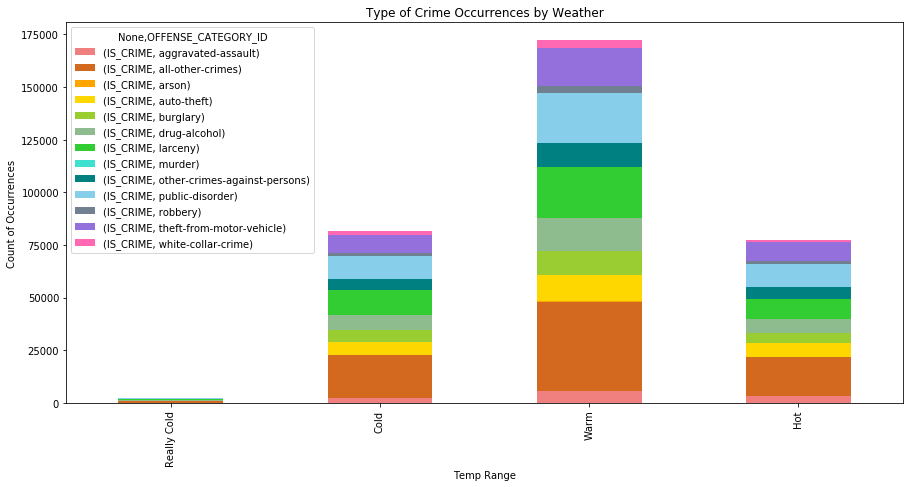

In [54]:
# stacked bar chart
colors = ['lightcoral','chocolate','orange','gold','yellowgreen','darkseagreen','limegreen','turquoise','teal','skyblue',
          'slategrey','mediumpurple','hotpink']
pivot_df.plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.ylabel("Count of Occurrences")
plt.title("Type of Crime Occurrences by Weather")
plt.show()

# What TRAFFIC VIOL occurs the most in cold, warm, and hot temperatures?

In [67]:
# filter out crime violations
istraffic_df = cw_orig[cw_orig['IS_TRAFFIC']==1]
istraffic_df.head()

,Unnamed: 0,Code,Offense_Type,OFFENSE_CATEGORY_ID,Address,Lon,Lat,Precint,Neighborhood,IS_CRIME,IS_TRAFFIC,Date,city_name,Temp,Temp Max,Wind,Clouds,Temp Range
8,8,5401,traffic-accident-hit-and-run,traffic-accident,W 13TH AVE / N CHEROKEE ST,-104.991650,39.736863,611,civic-center,0,1,2018-01-30 09:00:00,Denver,44.94,53.60,12.75,75.0,Warm
19,19,5441,traffic-accident,traffic-accident,N HAVANA ST / I70 HWYWB,-104.865745,39.775833,511,stapleton,0,1,2018-01-30 13:00:00,Denver,40.77,41.00,3.36,1.0,Warm
21,21,5441,traffic-accident,traffic-accident,E LOWRY BLVD / N YOSEMITE WAY,-104.883908,39.723506,321,lowry-field,0,1,2018-01-29 14:00:00,Denver,28.92,30.20,9.17,40.0,Cold
22,22,5401,traffic-accident-hit-and-run,traffic-accident,29TH ST / WELTON ST,-104.975646,39.756668,211,five-points,0,1,2018-01-30 16:00:00,Denver,54.63,57.20,13.87,75.0,Warm
43,43,5441,traffic-accident,traffic-accident,E 6TH AVE / N IVY LN,-104.920437,39.725338,321,hilltop,0,1,2018-01-30 17:00:00,Denver,51.85,51.98,16.11,75.0,Warm


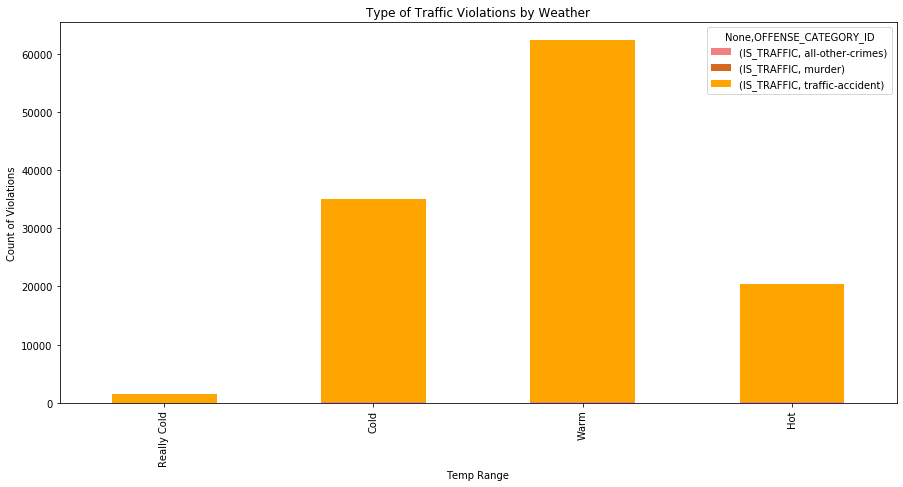

In [68]:
# traffic violation vs temp table 
traffic_temp = istraffic_df[['OFFENSE_CATEGORY_ID','IS_TRAFFIC','Temp Range']]
traffic_pivot = traffic_temp.pivot_table(traffic_temp, index='Temp Range', columns='OFFENSE_CATEGORY_ID', 
                                  aggfunc='count')
# stacked bar chart
# traffic_pivot.plot.bar(stacked=True, color=colors, figsize=(15,7))
# plt.ylabel("Count of Violations")
# plt.title("Type of Traffic Violations by Weather")
# plt.show()

In [70]:
traffic_type = istraffic_df[istraffic_df['OFFENSE_CATEGORY_ID']=="traffic-accident"]
traffic_df = pd.DataFrame(traffic_type)
traffic_df['Offense_Type'].value_counts()

traffic-accident                83697
traffic-accident-hit-and-run    33419
traffic-accident-dui-duid        3350
Name: Offense_Type, dtype: int64

# Burglary Plot

In [ ]:
burg = iscrime_df[iscrime_df['OFFENSE_CATEGORY_ID']=="burglary"]
burg_df = pd.DataFrame(burg)
burg_df['Offense_Type'].value_counts()

In [63]:
# Burglary
burg = iscrime_df[iscrime_df['OFFENSE_CATEGORY_ID']=="burglary"]
burg_df = pd.DataFrame(burg)
burg_df['Offense_Type'].value_counts()

burglary-residence-no-force      8154
burglary-residence-by-force      6556
burglary-business-by-force       4646
burglary-business-no-force       1657
burglary-poss-of-tools            470
burg-auto-theft-resd-no-force     417
burg-auto-theft-resd-w-force      155
burg-auto-theft-busn-w-force      134
burglary-safe                      85
burg-auto-theft-busn-no-force      46
Name: Offense_Type, dtype: int64

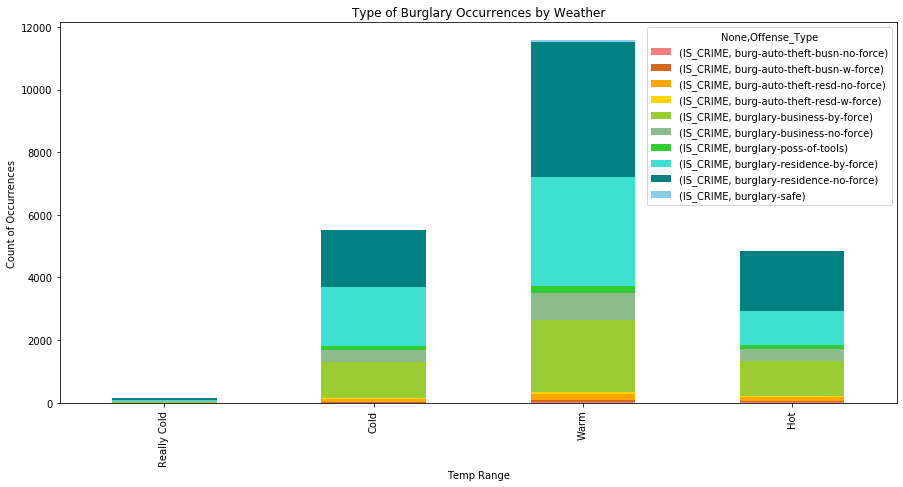

In [66]:
# stacked Burglary
burg_plot = burg_df[['Offense_Type','IS_CRIME','Temp Range']]
burg_pivot = burg_plot.pivot_table(burg_plot, index='Temp Range', columns='Offense_Type', aggfunc='count')
burg_pivot.plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.ylabel("Count of Occurrences")
plt.title("Type of Burglary Occurrences by Weather")
plt.show()

# Murder Plot

In [73]:
murder = iscrime_df[iscrime_df['OFFENSE_CATEGORY_ID']=="murder"]
murder_df = pd.DataFrame(murder)
murder_df['Offense_Type'].value_counts()

homicide-other             247
homicide-family             25
traf-vehicular-homicide     24
homicide-police-by-gun       2
homicide-negligent           2
Name: Offense_Type, dtype: int64

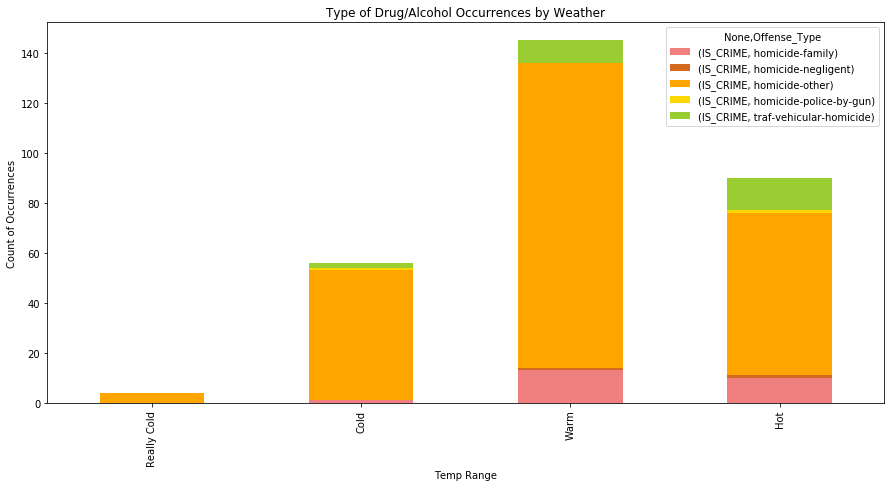

In [74]:
# stacked Drug-Alcohol
murder_plot = murder_df[['Offense_Type','IS_CRIME','Temp Range']]
murder_pivot = murder_plot.pivot_table(murder_plot, index='Temp Range', columns='Offense_Type', aggfunc='count')
murder_pivot.plot.bar(stacked=True, color=colors, figsize=(15,7))
plt.ylabel("Count of Occurrences")
plt.title("Type of Drug/Alcohol Occurrences by Weather")
plt.show()

#